# Summary
This assignment is the second step in preparation for the term project. It involves developing a simulation and testing a controller for the simplified model of the pivoting platform completed in HW 0x02: System Modeling. The code for this assignment is written in Python3 within a Jupyter notebook.

# Setup
These Python libraries are required to enable symbolic computation, create data visualizations, and solve an initial value problem for a system of ODEs, which are necessary steps to complete this assignment.

In [1]:
from sympy import *
from matplotlib import pyplot as plot
from scipy.integrate import solve_ivp

# System Variables
The `symbols()` function from the `sympy` Python library enables symbolic computations, which is useful for rearranging equations and representing the system variables in various different forms.

In [2]:
x, x_dot, theta, theta_dot, T_m = symbols("x v theta omega T_m")

# Known Parameters
The following tokens represent constant numerical parameters of the system.

In [3]:
r_m = 60e-3    # Radius of Lever Arm [m]
l_r = 50e-3    # Length of Push Rod [m]
r_b = 10.5e-3  # Radius of Ball [m]
r_g = 42e-3    # Vertical Distance from U-Joint to CG of Platform [m]
l_p = 110e-3   # Horizontal Distance from U-Joint to Push-Rod Pivot [m]
r_p = 32.5e-3  # Vertical Distance from U-Joint to Push-Rod Pivot [m]
r_c = 50e-3    # Vertical Distance from U-Joint to Platform Surface [m]
m_b = 30e-3    # Mass of Ball [kg]
m_p = 400e-3   # Mass of Platform [kg]
I_p = 1.88e-3  # Moment of Inertia of Platform [kg m^2]
b   = 10e-3    # Viscous friction at U-Joint [N m s / rad]
I_b = (2/5)*m_b*r_b**2 # Inertia of the ball [kg m^2]

g = 9.81  # Gravity [m / s^2]

# Rearranging to State-Space Form
In HW 0x02, the analytical model of the system could be represented in the form:

$$
\begin{bmatrix} 
M_{11}(x, \theta_y) & M_{12}(x, \theta_y) \\
M_{21}(x, \theta_y) & M_{22}(x, \theta_y) 
\end{bmatrix}
\begin{bmatrix}
\ddot{x} \\
\ddot{\theta}_y 
\end{bmatrix}
= \begin{bmatrix} 
f_1(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x \\
f_2(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x) 
\end{bmatrix},
$$

where the matrix $M$ contains the coefficients of the unknown highest order derivatives, $\ddot{x}$ is the acceleration of the ball parallel to the plate, $\ddot{\theta_y}$ is the angular acceleration of the platform, and $f_1$ and $f_2$ are functions of lower order terms and the motor torque. 

However, this model would be complex to simulate since it is a nonlinear representation of the system
and does not express $\ddot{x}$ and $\ddot{\theta_y}$ explicitly. Therefore, to simplify the simulation, the system model needs to be linearized and expressed in traditional state-space form:
$$
\dot{x} = A x + B u
$$
where the state vector is defined as:
$$
\vec{x} = \begin{bmatrix} x & \theta_y & \dot{x} & \dot{\theta}_y \end{bmatrix}^\top.
$$

This requires manipulation of the equations determined in HW 0x02. Using the equations determined in HW 0x02, the matrix $M$ can be represented in symbolic notation using Python code as:

In [4]:
M11 = -m_b*r_b - m_b*r_c - I_b/r_b
M12 = -m_b*r_b**2 - 2*m_b*r_b*r_c - m_b*r_c**2 - m_p*r_g**2 - m_b*x**2 - I_b - I_p
M21 = -m_b*r_b - I_b/r_b
M22 = -m_b*r_b**2 - m_b*r_b*r_c - I_b

M = Matrix([[M11, M12], 
            [M21, M22]])

and the vector $f$ can be expressed as:

In [5]:
# Acceleration of ball
f1 = -g*m_b*r_b*sin(theta) - g*m_p*r_g*sin(theta) - g*m_b*r_c*sin(theta) - g*m_b*x*cos(theta) + T_m*l_p/r_m + b*theta_dot + 2*m_b*theta_dot*x*x_dot- m_b*r_b*theta_dot**2*x
# Acceleration of plate
f2 = -m_b*r_b*(x*theta_dot**2 + g*sin(theta))

f = Matrix([[f1], 
            [f2]])

The accelerations of the ball and platform can then be isolated by multiplying both sides of the equation by the inverse of the matrix $M$, which is denoted as $M^{-1}$:
$$
\begin{bmatrix} 
\ddot{x} \\ 
\ddot{\theta}_y 
\end{bmatrix}
= \begin{bmatrix} 
M_{11}(x, \theta_y) & M_{12}(x, \theta_y) \\ 
M_{21}(x, \theta_y) & M_{22}(x, \theta_y) 
\end{bmatrix}^{-1}
\begin{bmatrix} 
f_1(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x \\ 
f_2(x, \theta_y, \dot{x}, \dot{\theta}_y, T_x) 
\end{bmatrix}
$$
The right hand side of the equation can be expressed as a vector:
$$
\vec{q} = \vec{M^{-1}} \cdot \vec{f}
$$
In Python, this is written as:

In [6]:
q = M.inv() * f

# Jacobian Linearization
The Jacobian matrix is the matrix of all of the first-order partial derivatives of a vector-valued function, which represents the differential of the system with respect to each variable. The Jacobian matrix of the system state model $A$ is represented as:

$$
\mathbf{A} =
\begin{bmatrix}
0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & 1 \\ 
\frac{\partial q_1}{\partial x} & \frac{\partial q_1}{\partial \theta_y} & \frac{\partial q_1}{\partial \dot{x}} & \frac{\partial q_1}{\partial \dot{\theta_y}} \\
\frac{\partial q_2}{\partial x} & \frac{\partial q_2}{\partial \theta_y} & \frac{\partial q_2}{\partial \dot{x}} & \frac{\partial q_2}{\partial \dot{\theta_y}} \\
\end{bmatrix}
$$
In Python, this is expressed as:

In [7]:
A11 = diff(q[0], x)           # Acceleration of ball WRT ball position
A12 = diff(q[0], theta)       # Acceleration of ball WRT platform position
A13 = diff(q[0], x_dot)       # Acceleration of ball WRT ball velocity
A14 = diff(q[0], theta_dot)   # Acceleration of ball WRT platform velocity
A21 = diff(q[1], x)           # Acceleration of platform WRT ball position
A22 = diff(q[1], theta)       # Acceleration of platform WRT platform position
A23 = diff(q[1], x_dot)       # Acceleration of platform WRT ball velocity
A24 = diff(q[1], theta_dot)   # Acceleration of platform WRT platform velocity

A = Matrix([[  0,   0,   1,   0], 
            [  0,   0,   0,   1], 
            [A11, A12, A13, A14], 
            [A21, A22, A23, A24]])

The Jacobian of the input matrix $B$ can be calculated in a similar manner by taking the partial derivative of each element in $\vec{q}$ with respect to the input, $T_m$.

$$
\mathbf{B} =
\begin{bmatrix}
0 \\
0 \\
\frac{\partial q_1}{\partial T_m} \\
\frac{\partial q_2}{\partial T_m} \\
\end{bmatrix}
$$

In Python, this is expressed as:

In [8]:
B = Matrix([[0              ], 
            [0              ], 
            [diff(q[0], T_m)],   # Acceleration of ball WRT motor torque
            [diff(q[1], T_m)]])  # Acceleration of platform WRT motor torque

Evaluating the Jacobian at the operating point provides a linear approximation for the system. One assumption that can be made here is that the system will operate close to equilibrium, or in other words, the plate will operate close to parallel with the ground and the ball will be close to the center of the platform. Following these assumptions, we can set the position and velocity of the ball as well as the position and velocity of the platform equal to zero at the equilibrium point of the system:

$$
x, \theta_y, \dot{x}, \dot{\theta_y} = 0
$$

Using the above assumption, the simulation should be accurate for initial conditions close to equilibrium. The linearization results in the following values for $A$ and $B$:

In [9]:
A = A.subs({x: 0, theta: 0, x_dot: 0, theta_dot: 0, T_m: 0})
print('A = ')
A

A = 


Matrix([
[                0,                0, 1,                 0],
[                0,                0, 0,                 1],
[-5.21699855336124, 4.01109511649826, 0, 0.177268044626614],
[ 112.887140258203, 64.8294719768538, 0, -3.83578458233786]])

In [10]:
B = B.subs({x: 0, theta: 0, x_dot: 0, theta_dot: 0, T_m: 0})
print('B = ')
B

B = 


Matrix([
[                0],
[                0],
[ 32.4991415148792],
[-703.227173428607]])

# Simulation
For an open-loop simulation, the input vector $u = 0$. For a closed-loop simulation, a regulator is implemented using full state feedback, with an input vector $u = -Kx$. In matrix notation, this equation can be expressed as:

$$
u = -\begin{bmatrix} K_1 & K_2 & K_3 & K_4 \end{bmatrix}
\begin{bmatrix}
x \\
\theta_y \\
\dot{x} \\
\dot{\theta_y}
\end{bmatrix}
$$

The gains used to test this system in closed-loop are:

$$
K = \begin{bmatrix} -0.3 & -0.2 & -0.05 & -0.02 \end{bmatrix}
$$

The individual gains in the $K$ matrix shown above are in SI units matching the states and input. That is, going left-to-right, the units for $K_1$ through $K_4$ are $[N]$, $[N \cdot m]$, $[N \cdot s]$, and $[N \cdot m \cdot s]$ respectively.

These gains implement a nearly fuel-optimal controller; that is, these gains stabilize the system while minimizing the amount of acutation effort required for stability. These gains will therefore _not_ offer high performance and would be expected to oscillate significantly.

# Functions
There are two functions necessary to produce simulations using the linearized system model determined above. `system_eq()` takes a `states` argument defining the initial conditions of the system, and a `loop` argument to determine whether to execute an open-loop simulation or a closed-loop simulation. This argument defines the behavior of the input vector $u$.

`system_eq()` returns the system model expressed in traditional state-space form: $\dot{x} = Ax + Bu$.

In [11]:
def system_eq(states, loop = 'closed'):    
    states = Matrix([[states[0]], 
                     [states[1]], 
                     [states[2]], 
                     [states[3]]])
    K = Matrix([[-0.30, -0.20, -0.05, -0.02]])
    u = 0 if loop == 'open' else -K * states
    x = A*states + B*u
    return [x[0], x[1], x[2], x[3]]

`graph()` uses the `pyplot` Python library to plot the responses of each state variable. It takes an argument `results` which is an object containing the response results of an ODE solver.

In [12]:
def graph(results):
    # Show 4 subplots
    fig, ax = plot.subplots(2, 2, figsize = (20, 10))
    
    ax[0, 0].plot(results.t, results.y[0])
    ax[0, 0].set_ylabel('Position $\mathit{x}$ [m]')
    ax[0, 0].set_title('Position Response of Ball')
    
    ax[0, 1].plot(results.t, results.y[1])
    ax[0, 1].set_ylabel('Angular Position $\mathit{θ_p}$ [rad]')
    ax[0, 1].set_title('Position Response of Platform')
    
    ax[1, 0].plot(results.t, results.y[2])
    ax[1, 0].set_ylabel('Velocity $\mathit{\dot{x}}$ [m/s]')
    ax[1, 0].set_title('Velocity Response of Ball')                 
    
    ax[1, 1].plot(results.t, results.y[3])
    ax[1, 1].set_ylabel('Angular Velocity $\mathit{\dot{θ_p}}$ [rad/s]')
    ax[1, 1].set_title('Velocity Response of Platform')

    for row in range(len(ax)):
        for col in range(len(ax)):
            ax[row, col].grid(True, alpha = 0.5)
            ax[row, col].tick_params(direction = 'in')
            ax[row, col].set_xlim(xmin = 0)
            ax[row, col].set_xlabel('Time $\mathit{t}$ [s]')

    plot.show()

# Results
The response of each system variable is shown below for different cases. The plots are generated using the `solve_ivp()` function from the `integrate` package within the `scipy` Python library. This function solves an initial value problem for a system of ODEs given the model returned by `system_eq()`, integrated over the interval `time` and given the initial `states`.

# Case 1: Open-Loop
The ball is initially at rest on a level platform directly above the center of gravity of the platform and there is no torque input from the motor. This simulation has been run for 1$[s]$. 

This response illustrates that the dynamic model is correct for this case, since the only way for the ball to remain balanced on the platform without any external input is if it is placed directly over the center of gravity and remains stationary.

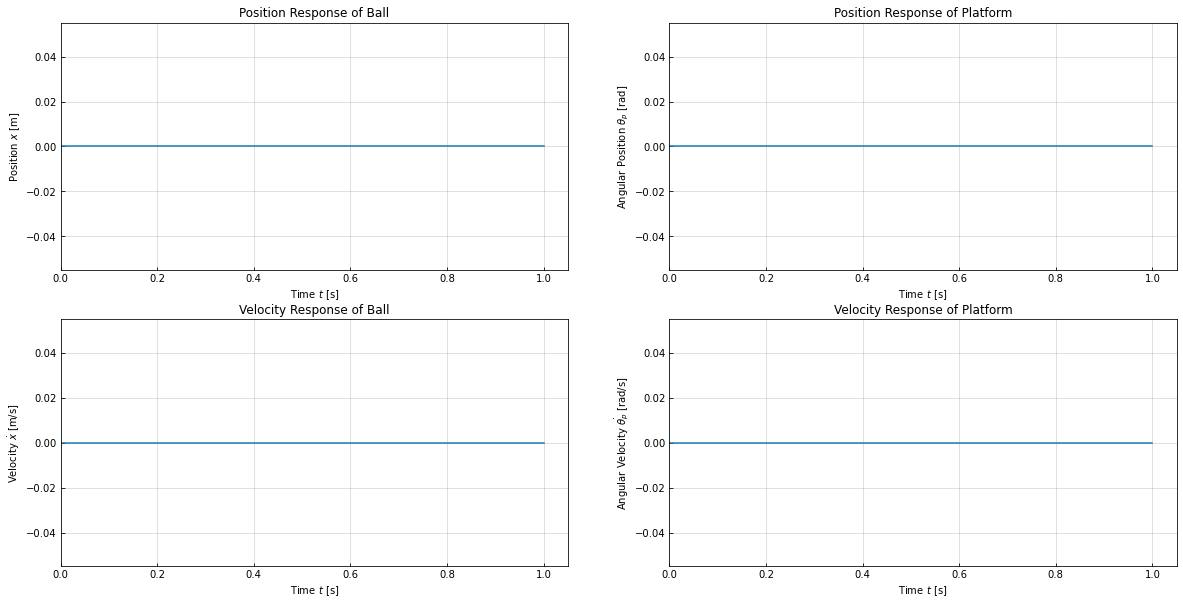

In [13]:
graph(solve_ivp(lambda time, states: system_eq(states, 'open'), 
                                     [0.0, 1.0],                      # simulation time
                                     [0, 0, 0, 0]))                   # initial conditions

# Case 2: Open-Loop
The ball is initially at rest on a level platform offset horizontally from the center of gravity of the platform by 5$[cm]$ and there is no torque input from the motor. This simulation has been run for 0.4$[s]$.

This response illustrates that the dynamic model is correct for this case, since the ball very quickly falls off of the platform when placed off-center. The platform also rapidly tilts away from parallel, which makes sense as well.

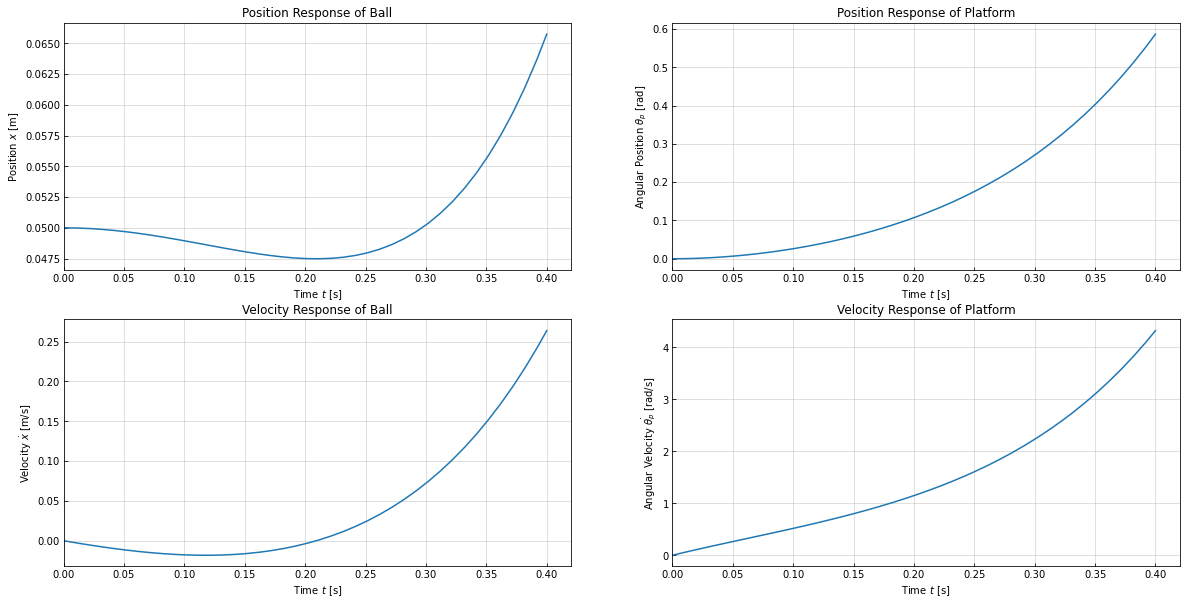

In [14]:
graph(solve_ivp(lambda time, states: system_eq(states, 'open'), 
                                     [0.0, 0.4],                      # simulation time
                                     [5e-2, 0, 0, 0],                 # initial conditions
                                     max_step = 0.01))

# Case 3: Closed-Loop
The ball is initially at rest on a level platform offset horizontally from the center of gravity of the platform by 5$[cm]$ and there is no torque input from the motor. This simulation has been run for 25$[s]$.

This response illustrates that the dynamic model is correct for this case, since the system states approach equilibrium as time passes. Since the gains in the matrix $K$ implement a nearly fuel-optimal controller, the amount of actuation effort required for stability is minimized, corresponding with the significant amount of oscillation in each response before equilibrium is achieved.

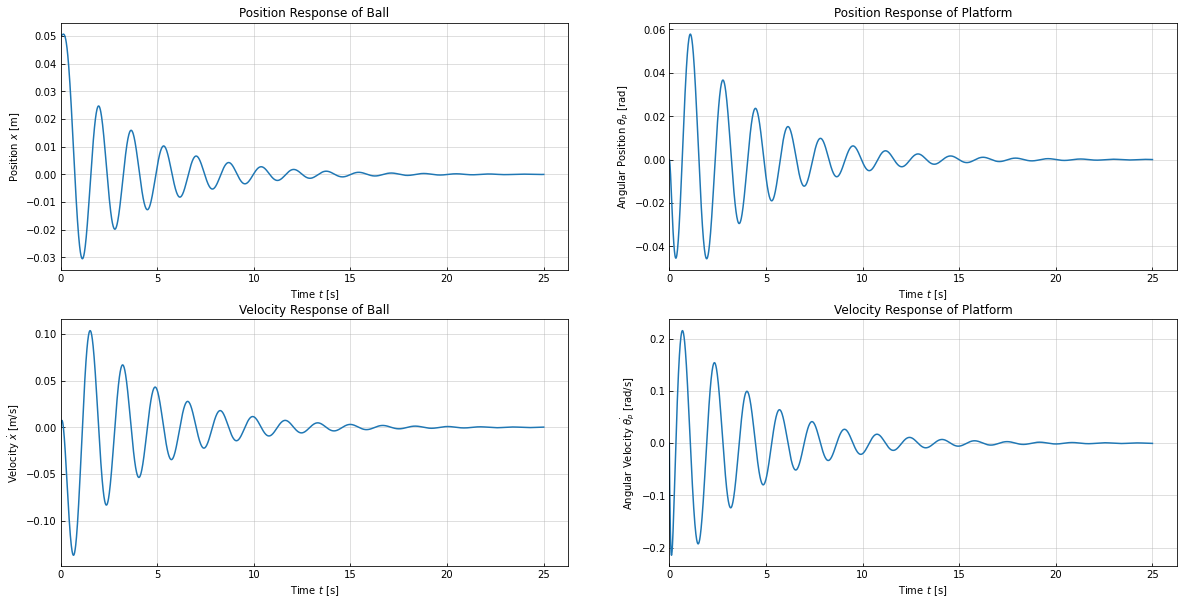

In [15]:
graph(solve_ivp(lambda time, states: system_eq(states, 'closed'), 
                                     [0.0, 25.0],                         # simulation time
                                     [5e-2, 0, 0, 0],                     # initial conditions
                                     max_step = 0.01))

# Conclusion
Each of the plots makes sense. For the open-loop simulation, there is no feedback to stabilize the system. Therefore, the only way for the open-loop system to remain stable is if the ball is placed directly over the center of gravity of the platform with no initial velocity. This validates the Case 1 and Case 2 scenarios. As shown in the Case 2 plots, when the initial ball position is even slightly offset from the center of gravity of the platform, the platform rapidly tilts to one side, causing the ball to roll off. For the Case 3 simulation, the plots approach a stable state due to the closed-loop gains.